In [13]:
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Distribuciones agrupadas por dominio
# ==============================================================================
distribuciones = [getattr(stats,d) for d in dir(stats) \
                  if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]

distribucion = []     
dominio_1 = []
dominio_2 = []

for dist in distribuciones:
    distribucion.append(dist.name)
    dominio_1.append(dist.a)
    dominio_2.append(dist.b)
    
info_distribuciones = pd.DataFrame({
                        'distribucion': distribucion,
                        'dominio_1': dominio_1,
                        'dominio_2': dominio_2
                      })

info_distribuciones = info_distribuciones \
                      .sort_values(by=['dominio_1', 'dominio_2'])\
                      .reset_index(drop=True)

print("-------------------------------------")
print("Información distribuciones scipy.stat")
print("-------------------------------------")
display(info_distribuciones)

-------------------------------------
Información distribuciones scipy.stat
-------------------------------------


,distribucion,dominio_1,dominio_2
0,levy_l,-inf,0.0
1,weibull_max,-inf,0.0
2,cauchy,-inf,inf
3,crystalball,-inf,inf
4,dgamma,-inf,inf
...,...,...,...
121,pareto,1.0,inf
122,truncpareto,1.0,inf
123,yulesimon,1.0,inf
124,zipf,1.0,inf


In [3]:
from scipy import stats
import pandas as pd
import numpy as np
import tqdm
import inspect
import warnings
warnings.filterwarnings('ignore')

def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats
    
    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
        
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''
    
    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
    
    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
            
    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)
    
    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)
    
    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
        
    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
        
    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]
    
    
    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(info_distribuciones)
    
    return seleccion


def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones 
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
    
    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.
    
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----

    '''
    
    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []
    
    for i, distribucion in enumerate(distribuciones):
        
        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
        
        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
            
            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)
            
            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,
                
                         })
            
            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)
            
        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")
            
    return resultados

In [8]:
# Datos
# ==============================================================================
datos = sns.load_dataset('diamonds')
datos = datos.loc[datos.cut == 'Fair', 'price']

In [17]:
type(datos)

pandas.core.series.Series

In [18]:
precios = pd.read_excel('../data/data.xlsx', header=0, index_col=0, parse_dates=True)
precios = precios.dropna()
retornos = np.log(precios).diff().dropna()
retornos

,AAPL,BTC-USD,IEF,ELE.MC,CSCO,MSFT,ORCL,IAU,TSLA,IBM,INTC
Date,,,,,,,,,,,
2014-09-18,0.002065,-0.074643,-0.000683,0.008327,0.000397,0.003433,0.009917,0.002533,0.009292,0.004915,0.005417
2014-09-19,-0.008187,-0.072402,0.003795,0.004727,-0.000793,0.017835,-0.043031,-0.005920,-0.017204,0.001289,-0.010002
2014-09-22,0.000990,0.018461,0.002135,0.009055,-0.009169,-0.009727,-0.005543,-0.002548,-0.036482,-0.004598,-0.003164
2014-09-23,0.015514,0.080333,0.002130,0.001501,-0.010872,-0.010682,-0.019131,0.005935,0.001519,-0.007746,-0.008390
2014-09-24,-0.008709,-0.029306,-0.002809,0.012587,0.011272,0.011106,0.015080,-0.003387,0.006885,0.003594,0.009542
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28,0.001524,0.025063,0.002734,-0.003376,0.012701,0.002714,0.014518,-0.005360,0.024155,-0.011168,0.016335
2023-09-29,0.003042,-0.004073,0.000218,0.002858,-0.002230,0.006705,-0.002169,-0.010236,0.015465,-0.009082,0.010462
2023-10-02,0.014727,0.022743,-0.008145,-0.036185,0.011651,0.018979,0.007431,-0.010053,0.005500,0.003557,-0.002535


In [41]:
datos = retornos.loc[:, 'BTC-USD']
datos

Date
2014-09-18   -0.074643
2014-09-19   -0.072402
2014-09-22    0.018461
2014-09-23    0.080333
2014-09-24   -0.029306
                ...   
2023-09-28    0.025063
2023-09-29   -0.004073
2023-10-02    0.022743
2023-10-03   -0.003668
2023-10-04    0.013378
Name: BTC-USD, Length: 2256, dtype: float64

In [42]:
# Ajuste y comparación de distribuciones
# ==============================================================================
resultados = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters that are outside the range allowed by the distribution.

20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: 

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,gennorm,4168.823143,-8331.646286,-8314.482240,3,"{'beta': 0.7855042411753586, 'loc': 0.00191938..."
1,genhyperbolic,4170.603835,-8331.207669,-8302.600926,5,"{'p': 0.3107012095835829, 'a': 0.1788018262631..."
2,dweibull,4168.580660,-8331.161320,-8313.997274,3,"{'c': 0.9105453490159623, 'loc': 0.00192996502..."
3,dgamma,4164.156806,-8322.313613,-8305.149567,3,"{'a': 0.8774871021466359, 'loc': 0.00196248145..."
4,norminvgauss,4159.911456,-8311.822913,-8288.937518,4,"{'a': 0.26190021402249913, 'b': 0.000514092244..."
5,johnsonsu,4154.053399,-8300.106798,-8277.221404,4,"{'a': -0.0215203514848024, 'b': 0.908572980738..."
6,tukeylambda,4148.193709,-8290.387419,-8273.223373,3,"{'lam': -0.3482361041554688, 'loc': 0.00189507..."
7,laplace,4146.167527,-8288.335054,-8276.892357,2,"{'loc': 0.0017672040006457834, 'scale': 0.0292..."
8,laplace_asymmetric,4146.172567,-8286.345134,-8269.181089,3,"{'kappa': 0.9969461396042723, 'loc': 0.0016395..."
9,t,4139.410807,-8272.821613,-8255.657568,3,"{'df': 2.143928342101737, 'loc': 0.00196266624..."


In [10]:
def plot_distribucion(x, nombre_distribucion, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5);
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribución')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    
    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    
    ax.legend();
    
    return ax

---------------------
Resultados del ajuste
---------------------
Distribución:   gennorm
Dominio:        [-inf, inf]
Parámetros:     {'beta': 0.7855042411753586, 'loc': 0.0019193883345603462, 'scale': 0.019210883937387735}
Log likelihood: 4168.823143105539
AIC:            -8331.646286211078
BIC:            -8314.482240373225


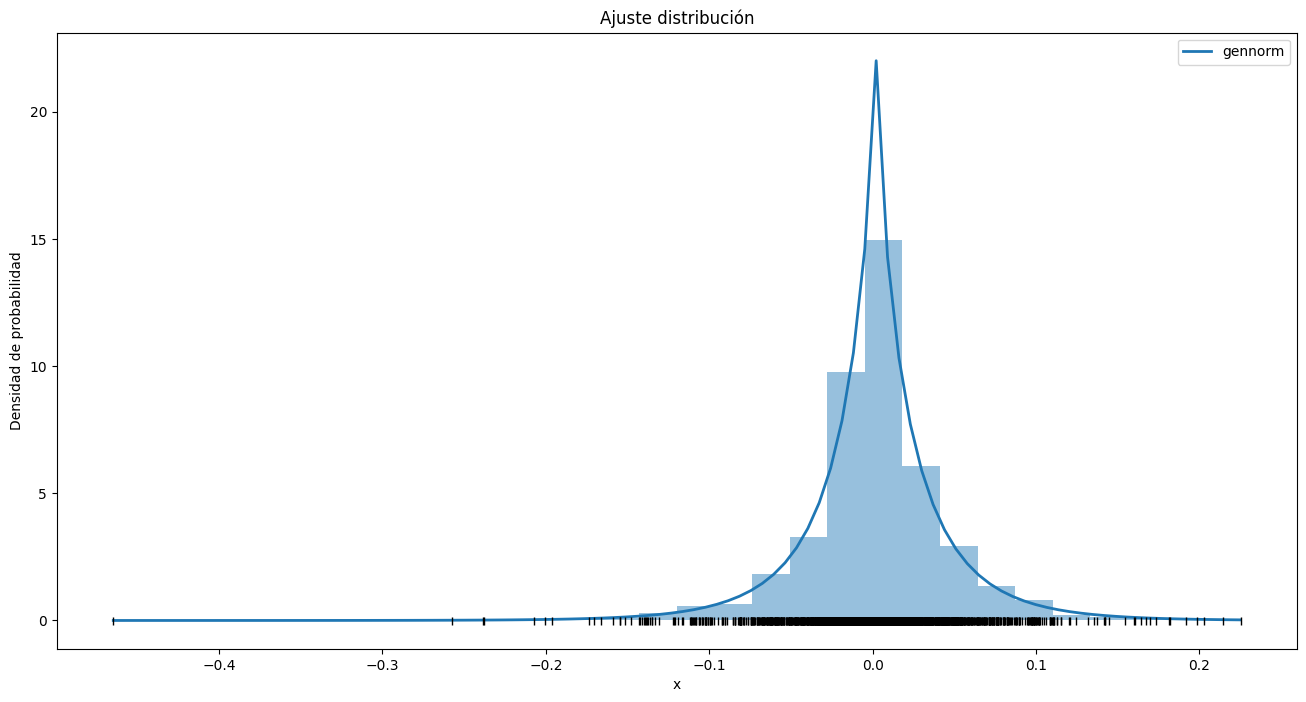

In [24]:
fig, ax = plt.subplots(figsize=(16,8))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][0],
    ax=ax
);

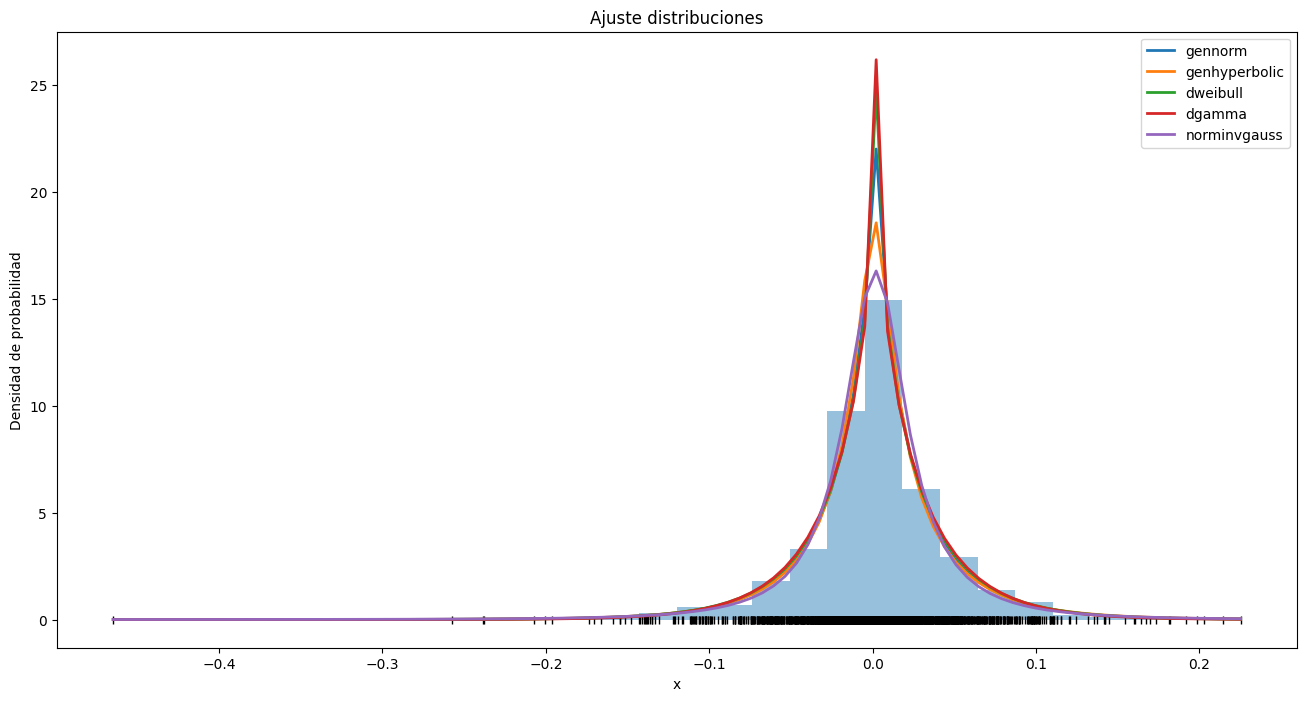

In [23]:
fig, ax = plt.subplots(figsize=(16,8))

plot_multiple_distribuciones(
    x=datos.to_numpy(),
    nombre_distribuciones=resultados['distribucion'][:5],
    ax=ax
);

In [25]:
datos = retornos.loc[:, 'IEF']
# Ajuste y comparación de distribuciones
# ==============================================================================
resultados = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters that are outside the range allowed by the distribution.

20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: 

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,dgamma,9272.897149,-18539.794299,-18522.630253,3,"{'a': 1.2439088537787184, 'loc': 5.71119819520..."
1,nct,9273.503914,-18539.007827,-18516.122433,4,"{'df': 4.915486954781745, 'nc': -0.08205475899..."
2,tukeylambda,9272.408101,-18538.816202,-18521.652156,3,"{'lam': -0.0799982362441389, 'loc': 5.50571756..."
3,johnsonsu,9273.069561,-18538.139122,-18515.253727,4,"{'a': 0.05193185446801006, 'b': 1.577076094078..."
4,genhyperbolic,9273.320823,-18536.641646,-18508.034903,5,"{'p': -2.3728033684970056, 'a': 0.340355890588..."
5,norminvgauss,9271.283480,-18534.566960,-18511.681566,4,"{'a': 1.274307256831595, 'b': -0.0326369207508..."
6,hypsecant,9269.012194,-18534.024389,-18522.581691,2,"{'loc': 4.210935307137036e-05, 'scale': 0.0026..."
7,dweibull,9269.526561,-18533.053123,-18515.889077,3,"{'c': 1.1334110808044804, 'loc': 5.68760787480..."
8,logistic,9262.798855,-18521.597711,-18510.155014,2,"{'loc': 2.5515727443315704e-05, 'scale': 0.002..."
9,genlogistic,9263.383046,-18520.766091,-18503.602045,3,"{'c': 0.9255778807581387, 'loc': 0.00027577956..."


---------------------
Resultados del ajuste
---------------------
Distribución:   dgamma
Dominio:        [-inf, inf]
Parámetros:     {'a': 1.2439088537787184, 'loc': 5.711198195204376e-05, 'scale': 0.0024595042090229616}
Log likelihood: 9272.897149460741
AIC:            -18539.794298921483
BIC:            -18522.63025308363


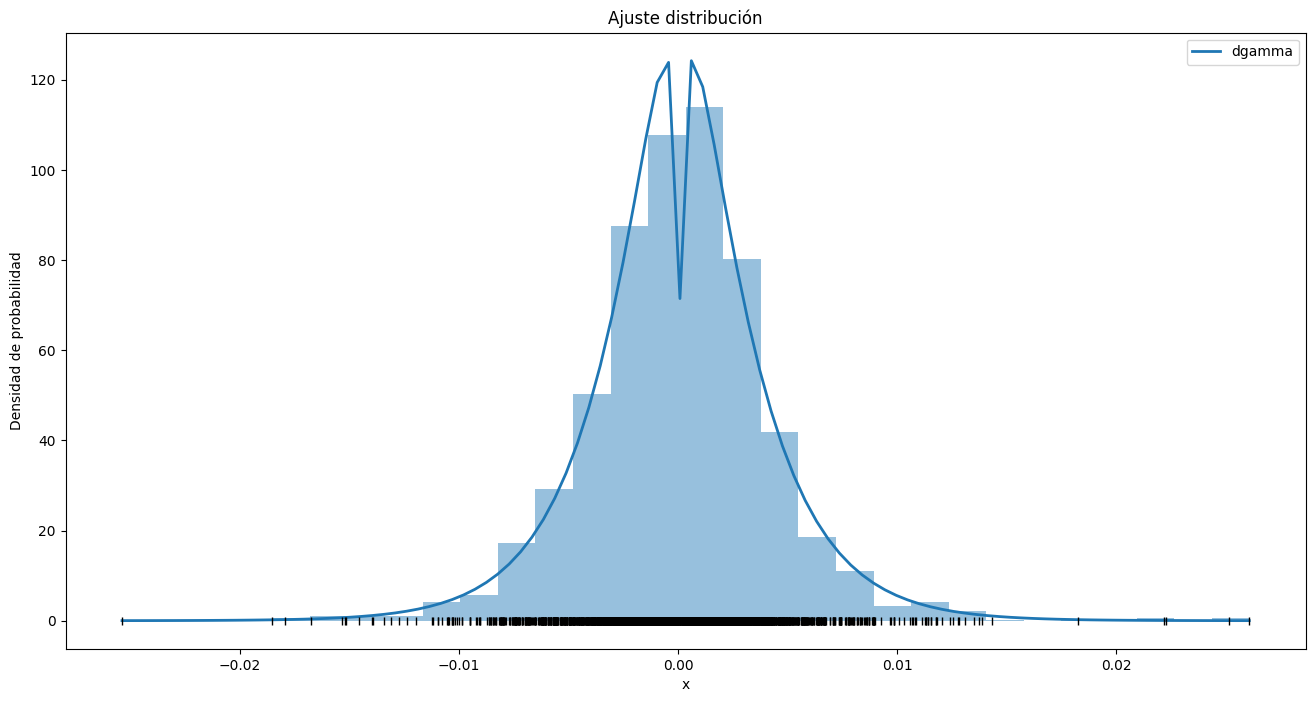

In [26]:
fig, ax = plt.subplots(figsize=(16,8))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][0],
    ax=ax
);

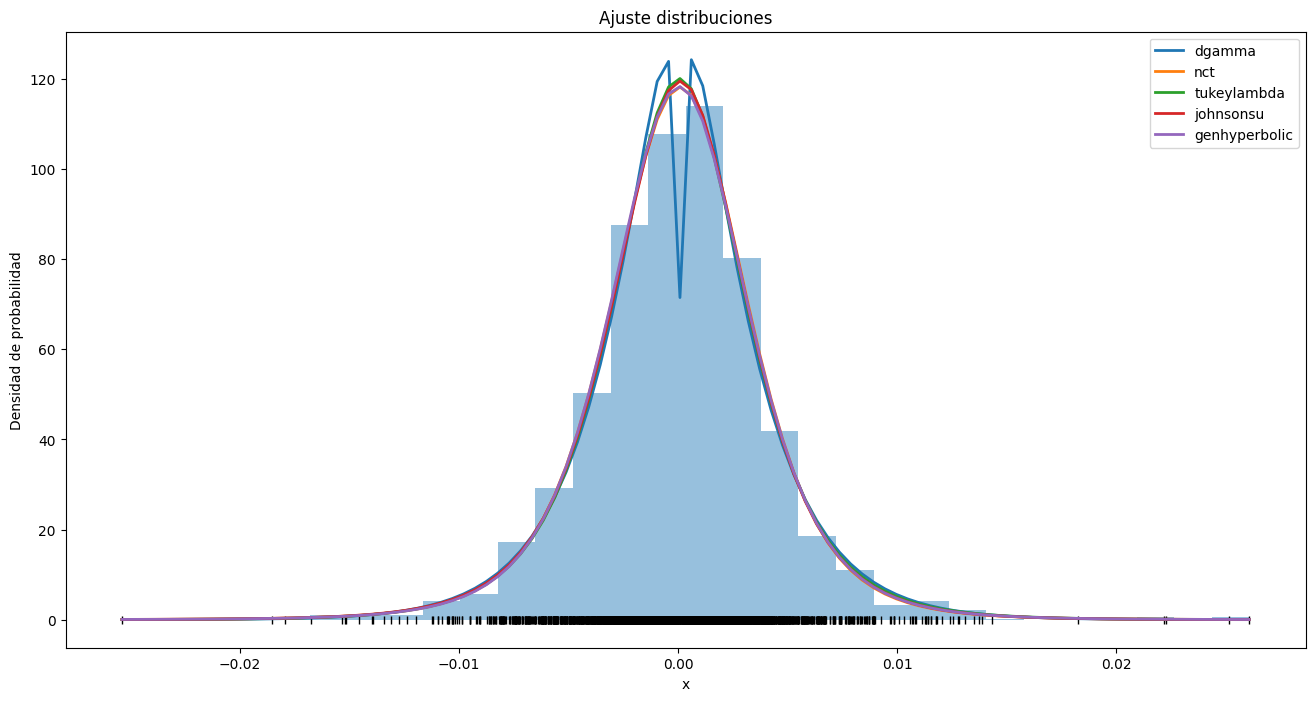

In [27]:
fig, ax = plt.subplots(figsize=(16,8))

plot_multiple_distribuciones(
    x=datos.to_numpy(),
    nombre_distribuciones=resultados['distribucion'][:5],
    ax=ax
);

In [43]:
nombre_distribucion=resultados['distribucion'][0]
# Generar el objeto de la distribución
distribucion_objeto = getattr(stats, nombre_distribucion)
# Usar el método fit para ajustar los datos a la distribución
parametros_ajustados = distribucion_objeto.fit(datos)

In [44]:
distribucion_objeto.ppf(0.05, *parametros_ajustados)

-0.06809714851017436